## Joining the data to create a new dataframe

In [1]:
# import all necessary libraries and packages
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# import CSV files into separate DataFrames
df1 = pd.read_csv('C:/Users/AM/OneDrive/Desktop/LHL/Python Project/data/oslo_bikes_data.csv')
df2 = pd.read_csv('C:/Users/AM/OneDrive/Desktop/LHL/Python Project/data/foursquare_museums.csv')
df3 = pd.read_csv('C:/Users/AM/OneDrive/Desktop/LHL/Python Project/data/foursquare_restobars.csv')
df4 = pd.read_csv('C:/Users/AM/OneDrive/Desktop/LHL/Python Project/data/yelp_museums.csv')
df5 = pd.read_csv('C:/Users/AM/OneDrive/Desktop/LHL/Python Project/data/yelp_restobars.csv')

In [3]:
# specifying the path to the SQLite database file
db_path = "C:/Users/AM/OneDrive/Desktop/LHL/Python Project/data/oslo.db"

# creating a connection to SQLite database
conn = sqlite3.connect(db_path)

In [4]:
# preparing DataFrames to SQLite tables

def write_dataframes_to_sql(data_frames, db_path):
    conn = sqlite3.connect(db_path)
    for table_name, df in data_frames.items():
        df.to_sql(table_name, conn, index=False, if_exists='replace')
    conn.close()

# define a dictionary of DataFrames
data_frames = {
    'bike_stations': df1,
    'fsq_museums': df2,
    'fsq_restobars': df3,
    'yelp_museums': df4,
    'yelp_restobars': df5
}

write_dataframes_to_sql(data_frames, db_path)

In [5]:
# list table names
tables = ['bike_stations', 'fsq_museums', 'fsq_restobars', 'yelp_museums', 'yelp_restobars']

# print column names for each table
for table_name in tables:
    query = f"SELECT * FROM {table_name} LIMIT 0"
    df = pd.read_sql_query(query, conn)
    print(f"\nColumns in {table_name}:")
    print(df.columns.tolist())

# Close the connection
conn.close()


Columns in bike_stations:
['Unnamed: 0', 'name', 'latitude', 'longitude', 'bikes_available', 'slots']

Columns in fsq_museums:
['bike_station_name', 'bike_station_lat', 'bike_station_lon', 'museum_name', 'museum_lat', 'museum_lon', 'distance']

Columns in fsq_restobars:
['Latitude', 'Longitude', 'Foursquare Name', 'Distance', 'Popularity', 'Rating', 'Price']

Columns in yelp_museums:
['bike_station_name', 'bike_station_lat', 'bike_station_lon', 'museum_name', 'museum_lat', 'museum_lon', 'distance']

Columns in yelp_restobars:
['Bike Station Latitude', 'Bike Station Longitude', 'Yelp Name', 'Distance', 'Review count', 'Rating', 'Price']


# Database

**TASK**: Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [6]:
# Cconnect to the database
conn = sqlite3.connect('oslo_data.db')
cursor = conn.cursor()

# create Bike Stations table
create_bike_stations_table = """
CREATE TABLE IF NOT EXISTS bike_stations (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    latitude REAL NOT NULL,
    longitude REAL NOT NULL,
    bikes_available INTEGER,
    slots INTEGER
);
"""

# create Foursquare Museums table
create_fsq_museums_table = """
CREATE TABLE IF NOT EXISTS fsq_museums (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    bike_station_name TEXT NOT NULL,
    bike_station_lat REAL NOT NULL,
    bike_station_lon REAL NOT NULL,
    museum_name TEXT NOT NULL,
    museum_lat REAL NOT NULL,
    museum_lon REAL NOT NULL,
    distance INTEGER
);
"""

# create Foursquare Restaurants and Bars table
create_fsq_restobars_table = """
CREATE TABLE IF NOT EXISTS fsq_restobars (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    latitude REAL NOT NULL,
    longitude REAL NOT NULL,
    name TEXT NOT NULL,
    distance INTEGER,
    popularity TEXT,
    rating REAL,
    price TEXT
);
"""

# create Yelp Museums table
create_yelp_museums_table = """
CREATE TABLE IF NOT EXISTS yelp_museums (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    bike_station_name TEXT NOT NULL,
    bike_station_lat REAL NOT NULL,
    bike_station_lon REAL NOT NULL,
    museum_name TEXT NOT NULL,
    museum_lat REAL NOT NULL,
    museum_lon REAL NOT NULL,
    distance INTEGER
);
"""

# create Yelp Restaurants and Bars table
create_yelp_restobars_table = """
CREATE TABLE IF NOT EXISTS yelp_restobars (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    bike_station_lat REAL NOT NULL,
    bike_station_lon REAL NOT NULL,
    name TEXT NOT NULL,
    distance REAL,
    review_count INTEGER,
    rating REAL,
    price TEXT
);
"""

# execute the create table queries
cursor.execute(create_bike_stations_table)
cursor.execute(create_fsq_museums_table)
cursor.execute(create_fsq_restobars_table)
cursor.execute(create_yelp_museums_table)
cursor.execute(create_yelp_restobars_table)

# Commit the changes and close the connection
conn.commit()
conn.close()

print("Tables created successfully.")

Tables created successfully.


> **DID YOU KNOW?**
<br> While sushi is absolutely a Japanese invention, they did not use salmon in the dish until it was suggested by a [Norwegian delegation in 1980's](https://www.lifeinnorway.net/norway-facts/).

Now let's insert data from dfs:

In [7]:
# connect to the database
conn = sqlite3.connect('oslo_data.db')

# insert data into bike_stations table
df1.to_sql('bike_stations', conn, if_exists='replace', index=False)

# insert data into fsq_museums table
df2.to_sql('fsq_museums', conn, if_exists='replace', index=False)

# insert data into fsq_restobars table
df3.to_sql('fsq_restobars', conn, if_exists='replace', index=False)

# insert data into yelp_museums table
df4.to_sql('yelp_museums', conn, if_exists='replace', index=False)

# insert data into yelp_restobars table
df5.to_sql('yelp_restobars', conn, if_exists='replace', index=False)

# commit the changes and close the connection
conn.commit()
conn.close()

print("Data inserted successfully.")

Data inserted successfully.


Here we are joining bike stations with nearby museums from both Foursquare and Yelp:

In [8]:
conn = sqlite3.connect('oslo_data.db')

query = """
SELECT 
    bs.name AS bike_station_name,
    bs.latitude AS bike_lat,
    bs.longitude AS bike_lon,
    bs.bikes_available,
    fsq.museum_name AS fsq_museum_name,
    fsq.distance AS fsq_distance,
    yelp.museum_name AS yelp_museum_name,
    yelp.distance AS yelp_distance
FROM 
    bike_stations bs
LEFT JOIN 
    fsq_museums fsq ON bs.name = fsq.bike_station_name
LEFT JOIN 
    yelp_museums yelp ON bs.name = yelp.bike_station_name
WHERE 
    fsq.distance IS NOT NULL OR yelp.distance IS NOT NULL
ORDER BY 
    bs.name, fsq.distance, yelp.distance
"""

df_result = pd.read_sql_query(query, conn)
conn.close()

print(df_result.head())

                  bike_station_name   bike_lat   bike_lon  bikes_available  \
0                   7. juni-plassen  59.915080  10.730589                4   
1                               AHO  59.925265  10.750462               16   
2                         Adamstuen  59.932792  10.734457                4   
3  Aker Brygge 1 mot Nasjonalmuseet  59.911184  10.730035               13   
4   Aker Brygge 2 mot Rådhusplassen  59.911115  10.730397               20   

                                     fsq_museum_name  fsq_distance  \
0                                       Ibsen Museum           194   
1                                 Cold ancient house           249   
2                                    NRK Opplevelser           474   
3  Mellomstasjonen – på vei til det nye Nasjonalm...            25   
4  Mellomstasjonen – på vei til det nye Nasjonalm...            47   

                                    yelp_museum_name  yelp_distance  
0                                       

# Visualizations
**TASK**: Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

*Judging from our columns, it would be interesting to check a correlation between rating/popularity of a restaurant or bar, and bikes available at nearby stations.*
*Let's use `fsq_restobars` for this.*

In [11]:
# connect to the database
conn = sqlite3.connect('oslo_data.db')

# query to get bike stations data with nearby restaurant/bar info
query = """
SELECT 
    bs.name, bs.latitude, bs.longitude, bs.bikes_available, bs.slots,
    AVG(fr.Rating) as avg_nearby_rating,
    AVG(fr.Popularity) as avg_nearby_popularity,
    COUNT(fr."Foursquare Name") as nearby_venue_count
FROM 
    bike_stations bs
LEFT JOIN 
    fsq_restobars fr ON (bs.latitude BETWEEN fr.Latitude - 0.001 AND fr.Latitude + 0.001)
                    AND (bs.longitude BETWEEN fr.Longitude - 0.001 AND fr.Longitude + 0.001)
GROUP BY 
    bs.name, bs.latitude, bs.longitude, bs.bikes_available, bs.slots
"""

df = pd.read_sql_query(query, conn)
conn.close()

print(df.head())
print(df.columns)

                               name   latitude  longitude  bikes_available  \
0                   7. juni-plassen  59.915080  10.730589                4   
1                               AHO  59.925265  10.750462               16   
2                         Adamstuen  59.932792  10.734457                4   
3  Aker Brygge 1 mot Nasjonalmuseet  59.911184  10.730035               13   
4   Aker Brygge 2 mot Rådhusplassen  59.911115  10.730397               20   

   slots  avg_nearby_rating  avg_nearby_popularity  nearby_venue_count  
0     21                0.0                    0.0                   1  
1     20                0.0                    0.0                   1  
2      8                0.0                    0.0                   1  
3     33                0.0                    0.0                   3  
4     24                0.0                    0.0                   3  
Index(['name', 'latitude', 'longitude', 'bikes_available', 'slots',
       'avg_nearby_rating

> **MORE NORWAY FACTS**
<br> Finnmark is home to the [oldest preserved ski ever found](https://www.lifeinnorway.net/norway-facts/), at an incredible 2,300-years old. To top it off, many Norwegian words including ski and slalom originated right here in Norway.

In [12]:
# calculate occupancy rate
df['occupancy_rate'] = df['bikes_available'] / df['slots']

# create usage categories
df['usage_cat'] = pd.cut(df['occupancy_rate'], 
                         bins=[0, 0.33, 0.66, 1], 
                         labels=['Low', 'Medium', 'High'])

### Pair Plot

<Figure size 1600x1400 with 0 Axes>

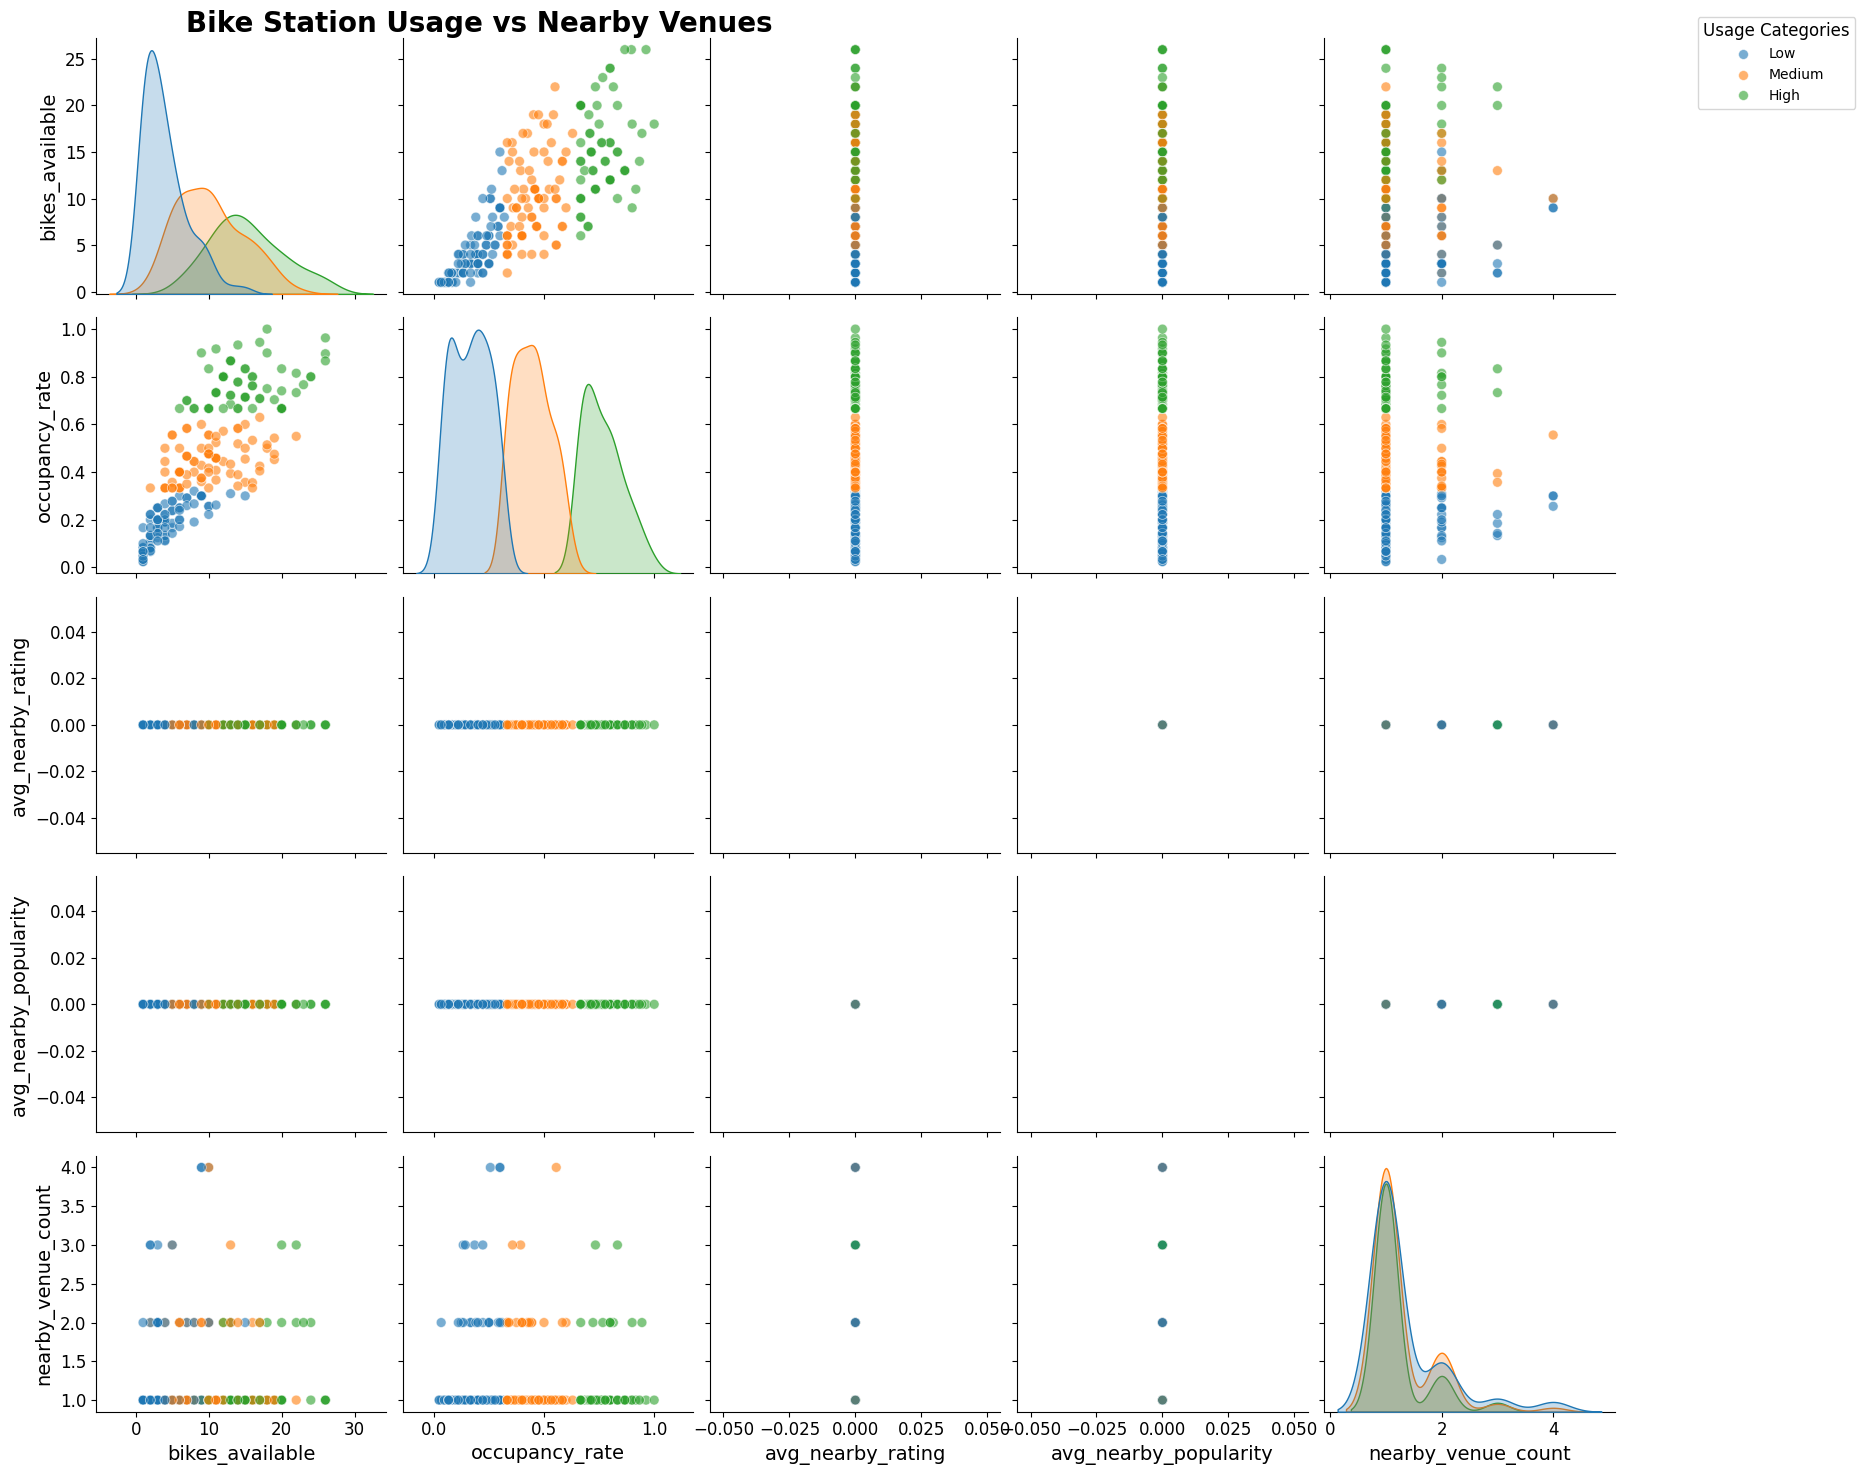

In [22]:
# select variables for the pair plot
plot_vars = ['bikes_available', 'occupancy_rate', 'avg_nearby_rating', 
             'avg_nearby_popularity', 'nearby_venue_count']

# create the pair plot
plt.figure(figsize=(16, 14))  # increased figure size to accommodate legend
pairplot = sns.pairplot(
    df, 
    vars=plot_vars,
    hue='usage_cat',
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's':50},
    height=3,  
    aspect=1.2 
)

# remove the original legend (it was covering the plot)
pairplot._legend.remove()

# customize the plot
pairplot.figure.suptitle("Bike Station Usage vs Nearby Venues", x=0.1, y=0.98, ha='left', va='top', fontsize=20, fontweight='bold')
for ax in pairplot.axes.flat:
    ax.tick_params(labelsize=12)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)

# add a custom legend
handles = pairplot._legend_data.values()
labels = pairplot._legend_data.keys()
pairplot.figure.legend(handles, labels, title="Usage Categories", 
                       loc='upper right', bbox_to_anchor=(0.98, 0.98),
                       fontsize=10, title_fontsize=12).set_alpha(0.7)


# adjust the layout
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for the legend

# show the plot
plt.show()

**Analysis of the pair plot**:

- bike availability seems to have a positive correlation with the occupancy rate, which is expected
- there's no significant correlation between bike availability and the average nearby ratings
- number of nearby venues doesn't seem to have a strong correlation with occupancy rate
- distribution of bike availability and occupancy rate appears to be right-skewed, indicating that most stations have fewer available bikes and lower occupancy rates

In [23]:
# save the plot
plt.savefig('oslo_bike_stations_pairplot.png', dpi=300, bbox_inches='tight')
print("Pair plot saved as 'oslo_bike_stations_pairplot.png'")

Pair plot saved as 'oslo_bike_stations_pairplot.png'


<Figure size 640x480 with 0 Axes>

### Histogram

<Figure size 1200x800 with 0 Axes>

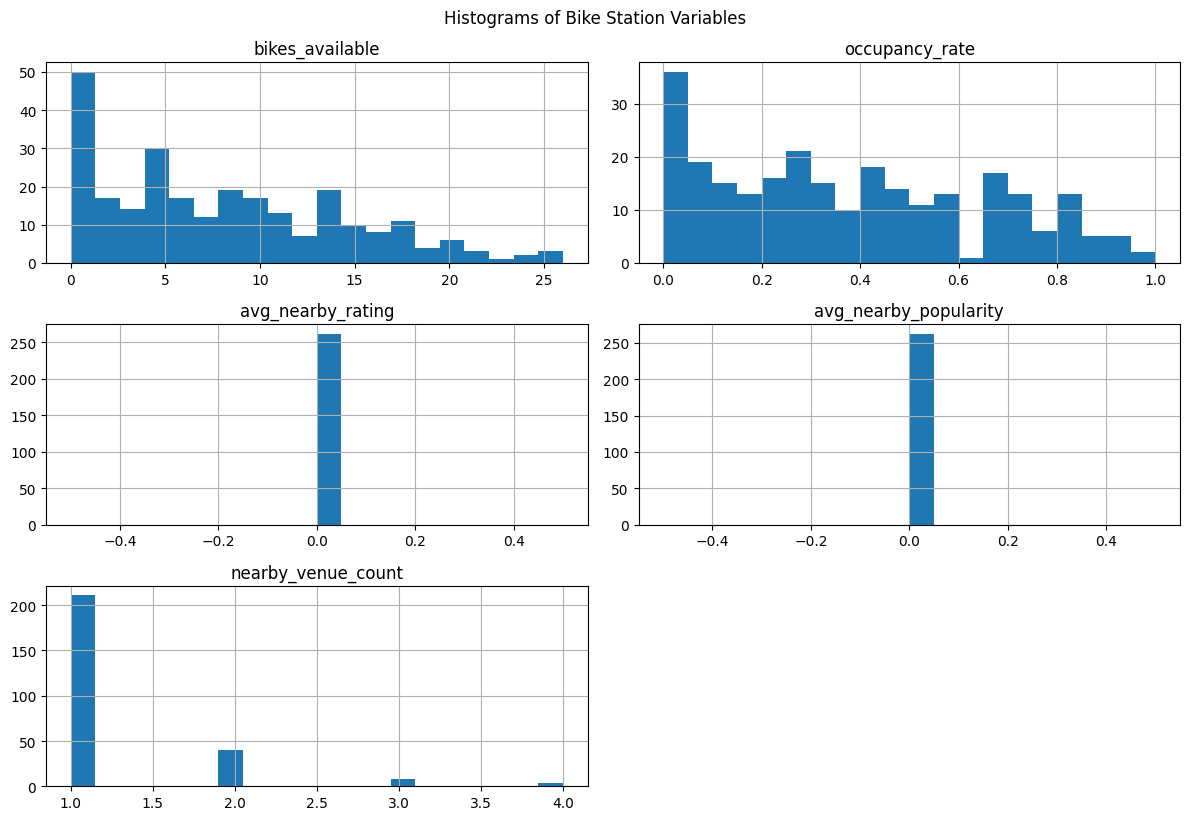

In [25]:
plt.figure(figsize=(12, 8))
df[plot_vars].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.suptitle("Histograms of Bike Station Variables", y=1.02)
plt.show()

In [26]:
# save the histograms
plt.savefig('oslo_histograms.png')
print("Histograms saved as 'oslo_histograms.png'")

Histograms saved as 'oslo_histograms.png'


<Figure size 640x480 with 0 Axes>

### Heatmap

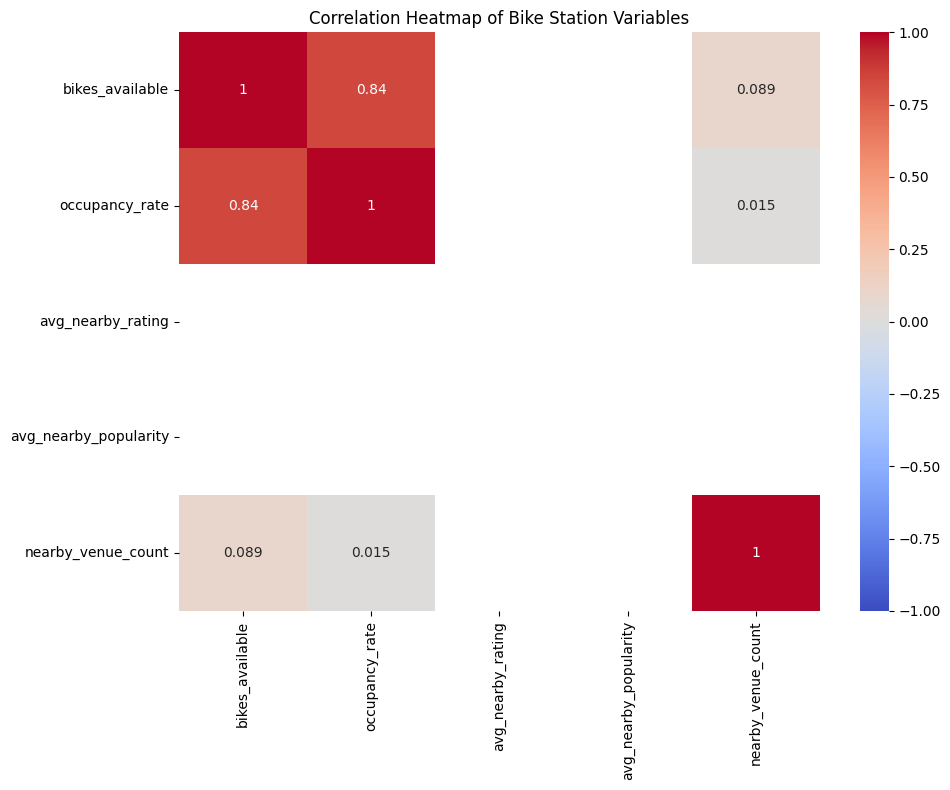

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[plot_vars].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Bike Station Variables')
plt.tight_layout()
plt.show()

In [29]:
#save heatmap
plt.savefig('oslo_heatmap.png')
print("Heatmap saved as 'oslo_heatmap.png'")

Heatmap saved as 'oslo_heatmap.png'


<Figure size 640x480 with 0 Axes>

### Mapping stations and museums

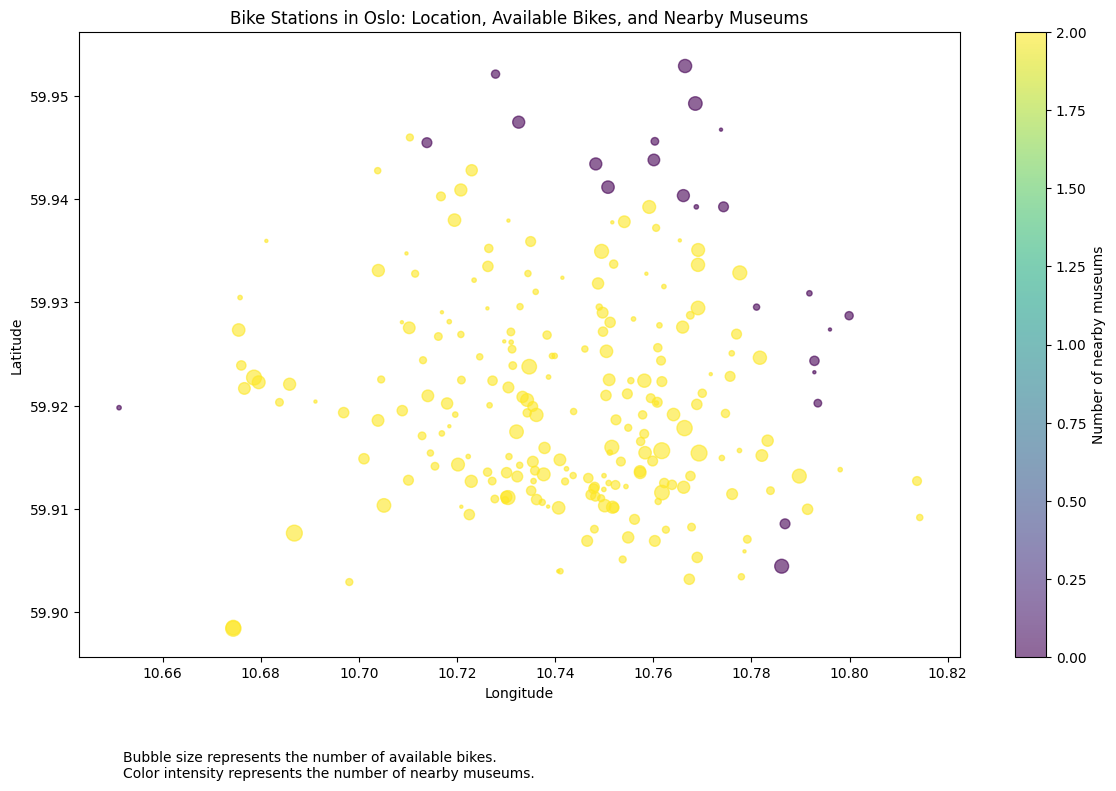

In [37]:
# connect to the database
conn = sqlite3.connect('oslo_data.db')

# query to get bike stations and nearby museums, plus their count
query = """
SELECT 
    bs.name AS bike_station_name,
    bs.latitude AS bike_lat,
    bs.longitude AS bike_lon,
    bs.bikes_available,
    COUNT(DISTINCT fsq.museum_name) AS fsq_museum_count,
    COUNT(DISTINCT yelp.museum_name) AS yelp_museum_count
FROM 
    bike_stations bs
LEFT JOIN 
    fsq_museums fsq ON bs.name = fsq.bike_station_name
LEFT JOIN 
    yelp_museums yelp ON bs.name = yelp.bike_station_name
GROUP BY 
    bs.name, bs.latitude, bs.longitude, bs.bikes_available
"""

df = pd.read_sql_query(query, conn)
conn.close()

# create the scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['bike_lon'], df['bike_lat'], 
                      c=df['fsq_museum_count'] + df['yelp_museum_count'], 
                      s=df['bikes_available']*5, 
                      alpha=0.6, cmap='viridis')

plt.colorbar(scatter, label='Number of nearby museums')
plt.title('Bike Stations in Oslo: Location, Available Bikes, and Nearby Museums')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# add a text annotation explaining the plot
plt.text(0.05, -0.15, 
         "Bubble size represents the number of available bikes.\n"
         "Color intensity represents the number of nearby museums.", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.show()


In [38]:
# saving the visualization
plt.savefig('oslo_bike_stations_museums.png')
print("Visualization saved as 'oslo_bike_stations_museums.png'")

Visualization saved as 'oslo_bike_stations_museums.png'


<Figure size 640x480 with 0 Axes>

This visualization resembles a map of Oslo! It would be nice to put a map as a backgound. This can be achieved with `matplotlib cartopy pillow` for static map or `folium` for interactive map at a later stage.

> **DID YOU KNOW?**
<br>Everyone living in Norway has three figures taken from their [annual tax return published](https://www.lifeinnorway.net/norway-facts/): their annual income, income tax paid, and total wealth. Yes, really!
<br>Prior to 2013, this data was completely open and searchable by anyone. That has since changed though, and now a person is able to see who has looked up their own data.